In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import pandas as pd
import seaborn as sns
from sklearn import linear_model
pd.set_option('display.max_rows', 40)
!date

Thu Mar 19 14:50:43 PDT 2020


# 2010 census demo data. looking for good predictors of bias seen in AIAN on-res counts and urban/rural by-county asian alone counts

Akee's talk here: https://vimeo.com/380264104

In [2]:
##Encoding of the AIANHH var:
#0001–4999 Federally recognized American Indian reservation and/or off-reservation trust land
#5000–5499 Hawaiian home land 5500–5999 Oklahoma tribal statistical area
#5500–5999 Oklahoma tribal statistical area
#6000–7999 Alaska Native village statistical area
#8000–8999 Tribal designated statistical area
#9000–9499 State-recognized American Indian reservation
#9500–9998 State designated tribal statistical area 

In [3]:
## Encoding of race vars
# White alone P0030002
# Black or African American alone P0030003
# American Indian and Alaska Native alone P0030004
# Asian alone P0030005
# Native Hawaiian and Other Pacific Islander alone P0030006 
# Some Other Race alone P0030007 
# Two or More Races P0030008 

In [4]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']

race_cols = ['P0030001','P0030002','P0030003','P0030004','P0030005','P0030006','P0030007','P0030008'] # race vars
keep_cols = location_cols + race_cols

def my_cols(x):
    if x.startswith('P001'):
        return True
    elif x.startswith(('AIAN','AITS','TTRACT','UA','UR')):
        return True
    else:
        return (x in keep_cols)

In [5]:
%%time

df_dp = pd.read_csv('/home/j/temp/abie/fiftystates2010dhc.csv', usecols=my_cols)
df_dp.backup = df_dp.copy(deep=True)

<string>:2: DtypeWarning: Columns (28,32,33,47,49,50) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 7min 14s, sys: 38.4 s, total: 7min 52s
Wall time: 7min 57s


/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [6]:
dta_columns = [x.lower() for x in df_dp.columns] #grab col names as lowercase
dta_columns[-9:] = df_dp.columns[-9:] #coded vars are capitalized
# dta_columns #check contents

In [7]:
%%time

# r = pd.read_stata('/home/j/temp/abie/all50states_2010ur1_all_vars.dta', columns=dta_columns,
#                  chunksize=100_000, convert_missing=True, preserve_dtypes=False)

# df_sf = pd.DataFrame()
# for t in r:
#     print('.', flush=True, end=' ')
#     df_sf = df_sf.append(t[t.block != ''])
# df_sf.shape

# #saved AIAN-relevant vars here; loads faster than the .dta
df_sf = pd.read_csv('/home/j/temp/beatrixh/2020_census/all50states_all_races_02_27_2020.csv')
df_sf.backup = df_sf.copy(deep=True)

<string>:2: DtypeWarning: Columns (7,10,11) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 14.2 s, sys: 5.02 s, total: 19.2 s
Wall time: 19.7 s


/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


In [8]:
# df_sf.to_csv(r'/home/j/temp/beatrixh/2020_census/all50states_all_races_02_27_2020.csv', index = None, header=True)

In [9]:
df_sf.columns = [x.upper() for x in df_sf.columns]
df_sf.columns

Index(['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'AIANHH', 'AIANHHFP',
       'AIANHHCC', 'AITSCE', 'AITS', 'AITSCC', 'TTRACT', 'UA', 'UASC',
       'UATYPE', 'UR', 'AIANHHNS', 'AITSNS', 'AIANHHSC', 'P0010001',
       'P0030001', 'P0030002', 'P0030003', 'P0030004', 'P0030005', 'P0030006',
       'P0030007', 'P0030008'],
      dtype='object')

In [10]:
# df_sf = df_sf.drop('UASC', axis=1)
df_dp = df_dp.drop('UASC', axis=1) #this is just NANs

In [11]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'AIANHH']

In [12]:
block_level = pd.merge(df_sf[df_sf.BLOCK.notnull()],
                       df_dp[df_dp.BLOCK.notnull()][location_cols + race_cols + ['P0010001']],
                       left_on=location_cols,
                       right_on=location_cols,
                       suffixes=('_SF', '_DP'))

In [13]:
# oh oops. i was missing DC, which had pop of 601_723
print(f'total population sum incl DC should be 308,745,538: {block_level.P0030001_SF.sum()+601_723}')

total population sum incl DC should be 308,745,538: 308745538


In [14]:
# first: by county, urban v rural aian
rural_block_level = block_level[block_level.UR=='R']
urban_block_level = block_level[block_level.UR=='U']

In [15]:
race_vars = [str(i) + '_SF' for i in race_cols + ['P0010001']] + [str(i) + '_DP' for i in race_cols + ['P0010001']]

In [16]:
rural_county_level = rural_block_level.groupby(['STATE','COUNTY'])[race_vars].apply(lambda x : x.astype(int).sum())
urban_county_level = urban_block_level.groupby(['STATE','COUNTY'])[race_vars].apply(lambda x : x.astype(int).sum())

# look at change at reservation level

In [17]:
# things to check:
# can you make it a function of total population... ? start with that. then.. what other things do you think might be predictors?
# maybe percent of total population?
# you could also checkout pct diff instead of abs diff

In [64]:
block_level_aiannh = block_level[block_level.AIANHH!=9999]

In [65]:
res_level_aian = block_level_aiannh.groupby(['AIANHH'])[race_vars].apply(lambda x : x.astype(int).sum())

In [66]:
# add var to predict
res_level_aian['count_diff'] = res_level_aian['P0030004_DP'] - res_level_aian['P0030004_SF']
res_level_aian['count_prop_diff'] = res_level_aian['P0030004_DP'] / res_level_aian['P0030004_SF']

In [67]:
#create selection vector to grab 80% of the data
select = np.random.binomial(1,p=0.8,size=res_level_aian.shape[0])
select = select.astype(bool)

In [68]:
#run regression: res-level aian count bias as a function of res-level total population
X = res_level_aian[['P0010001_SF']]
y = res_level_aian[['count_diff']]
lm = linear_model.LinearRegression()
model = lm.fit(X[select],y[select])

In [69]:
predictions = lm.predict(X)

In [70]:
# this was a terrible predictor. need to comb codebook for better vars. things to check
b = lm.intercept_[0]
m = lm.coef_[0]
print(f'''intercept: ,{b},
     coef: ,{m}''')

intercept: ,-49.92528454463772,
     coef: ,[-0.0001353]


In [71]:
#res-level aian count bias as a function of res-level aian population
X = res_level_aian[['P0030004_SF']]
y = res_level_aian[['count_diff']]
res_bias_aian_res_pop = linear_model.LinearRegression()
model = res_bias_aian_res_pop.fit(X[select],y[select])

In [72]:
#looks like a better predictor.
res_bias_aian_res_pop_b = res_bias_aian_res_pop.intercept_[0]
res_bias_aian_res_pop_m = res_bias_aian_res_pop.coef_[0]
print(f'''intercept: ,{res_bias_aian_res_pop_b},
     coef: ,{res_bias_aian_res_pop_m}''')

intercept: ,-38.6552172490148,
     coef: ,[-0.0081752]


In [73]:
#want to try proportion of pop given by aian
res_level_aian['aian_prop_SF'] = res_level_aian['P0030004_SF'] / res_level_aian['P0010001_SF']
res_level_aian['aian_prop_DP'] = res_level_aian['P0030004_DP'] / res_level_aian['P0010001_DP']

In [74]:
#what does the change look like on rows that were 0/0?
res_level_aian[res_level_aian.aian_prop_SF.isnull()][['count_diff','P0030004_SF','P0010001_SF']].describe()

,count_diff,P0030004_SF,P0010001_SF
count,58.000000,58.0,58.0
mean,1.741379,0.0,0.0
std,5.097507,0.0,0.0
min,0.000000,0.0,0.0
25%,0.000000,0.0,0.0
50%,0.000000,0.0,0.0
75%,0.000000,0.0,0.0
max,22.000000,0.0,0.0


In [75]:
#res-level aian count bias as a function of aian proportion of pop (by res)
#exluding all rows where proportion is 0/0
X = res_level_aian[res_level_aian.aian_prop_SF.notna()][['aian_prop_SF']]
y = res_level_aian[res_level_aian.aian_prop_SF.notna()][['count_diff']]
res_bias_aian_res_prop = linear_model.LinearRegression()
model = res_bias_aian_res_prop.fit(X,y)

In [76]:
res_bias_aian_res_prop_b = res_bias_aian_res_prop.intercept_[0]
res_bias_aian_res_prop_m = res_bias_aian_res_prop.coef_[0]
print(f'''intercept: ,{res_bias_aian_res_prop_b},
     coef: ,{res_bias_aian_res_prop_m}''')

intercept: ,-10.011897334986138,
     coef: ,[-73.84622473]


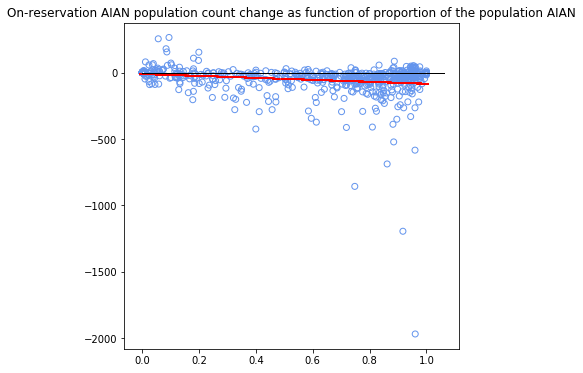

In [120]:
# plot preds
x = res_level_aian[["aian_prop_SF"]]
y = res_level_aian[["count_diff"]] 
z = res_level_aian[["aian_prop_SF"]]*res_bias_aian_res_prop_m+res_bias_aian_res_prop_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '_')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('On-reservation AIAN population count change as function of proportion of the population AIAN')

plt.show()

In [230]:
res_level_aian.shape

(692, 24)

In [123]:
res_level_aian.head()

,P0030001_SF,P0030002_SF,P0030003_SF,P0030004_SF,P0030005_SF,P0030006_SF,P0030007_SF,P0030008_SF,P0010001_SF,P0030001_DP,...,P0030004_DP,P0030005_DP,P0030006_DP,P0030007_DP,P0030008_DP,P0010001_DP,count_diff,count_prop_diff,aian_prop_SF,aian_prop_DP
AIANHH,,,,,,,,,,,,,,,,,,,,,
10,3011,47,3,2906,0,0,12,43,3011,3048,...,2903,2,1,6,84,3048,-3,0.998968,0.965128,0.952428
20,24781,21083,664,238,788,44,1350,614,24781,24953,...,190,889,69,1285,925,24953,-48,0.798319,0.009604,0.007614
50,608,32,8,552,0,0,1,15,608,461,...,310,0,0,6,8,461,-242,0.561594,0.907895,0.672451
80,6490,4508,52,1606,26,4,54,240,6490,6405,...,1558,28,0,37,229,6405,-48,0.970112,0.247458,0.243247
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN


In [145]:
res_level_aian['aian_prop_SF_round'] = np.around(res_level_aian.aian_prop_SF, decimals=2)

In [147]:
res_level_aian.aian_prop_SF_round.unique().size

100

In [130]:
res_level_aian['var_count_change'] = np.zeros(res_level_aian.shape[0]) #create a column to hold variance value

In [143]:
#create a column of variance for aian_prop_SF
for i in res_level_aian[res_level_aian.aian_prop_SF_round.notna()].aian_prop_SF_round.unique():
    var = np.var(res_level_aian[(res_level_aian.aian_prop_SF_round == i)].count_diff)
    res_level_aian.loc[(res_level_aian.aian_prop_SF_round == i),'var_count_change'] = var

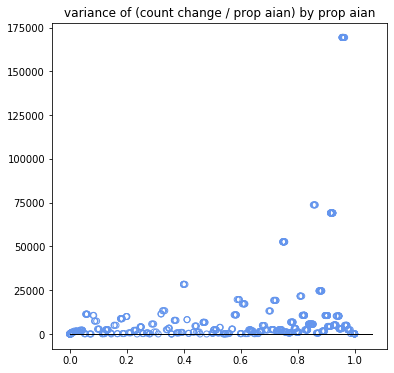

In [158]:
# plot preds
x = res_level_aian[["aian_prop_SF"]]
y = res_level_aian[["var_count_change"]] 
z = res_level_aian[["aian_prop_SF"]]*res_bias_aian_res_prop_m+res_bias_aian_res_prop_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
# ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '_')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('variance of (count change / prop aian) by prop aian')

plt.show()

In [149]:
#now: looking for predictors of variance in count diff per prop aian

In [151]:
#res-level aian count bias as a function of res-level aian population
X = res_level_aian[['P0030004_SF']]
y = res_level_aian[['var_count_change']]
var_by_aian_count = linear_model.LinearRegression()
model = var_by_aian_count.fit(X[select],y[select])

In [152]:
var_by_aian_count_b = var_by_aian_count.intercept_[0]
var_by_aian_count_m = var_by_aian_count.coef_[0]
print(f'''intercept: ,{var_by_aian_count_b},
     coef: ,{var_by_aian_count_m}''')

intercept: ,11088.0548782288,
     coef: ,[0.72265105]


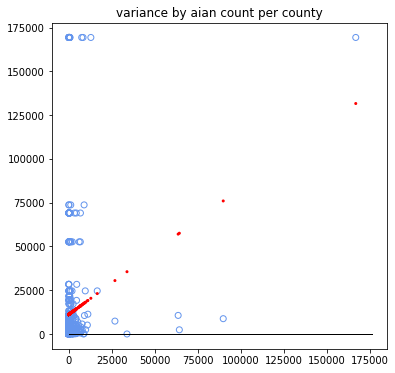

In [155]:
# plot preds
x = res_level_aian[["P0030004_SF"]]
y = res_level_aian[["var_count_change"]] 
z = res_level_aian[["P0030004_SF"]]*var_by_aian_count_m+var_by_aian_count_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('variance by aian count per county')

plt.show()

In [156]:
res_level_aian.columns

Index(['P0030001_SF', 'P0030002_SF', 'P0030003_SF', 'P0030004_SF',
       'P0030005_SF', 'P0030006_SF', 'P0030007_SF', 'P0030008_SF',
       'P0010001_SF', 'P0030001_DP', 'P0030002_DP', 'P0030003_DP',
       'P0030004_DP', 'P0030005_DP', 'P0030006_DP', 'P0030007_DP',
       'P0030008_DP', 'P0010001_DP', 'count_diff', 'count_prop_diff',
       'aian_prop_SF', 'aian_prop_DP', 'aian_prop_SF_round',
       'var_count_change'],
      dtype='object')

# asian rural bias

In [159]:
#is there a similar relationship for urban/rural asian alone bias?
rural_county_level['asian_count_diff'] = rural_county_level['P0030005_DP'] - rural_county_level['P0030005_SF']
rural_county_level['total_count_diff'] = rural_county_level['P0010001_DP'] - rural_county_level['P0010001_SF']
rural_county_level['prop_asian_SF'] = rural_county_level['P0030005_SF'] / rural_county_level['P0010001_SF']
rural_county_level['prop_asian_DP'] = rural_county_level['P0030005_DP'] / rural_county_level['P0010001_DP']

In [160]:
#rural asian bias as fn of proportion aian out of rural part of county
#exluding all rows where proportion is 0/0
X = rural_county_level[rural_county_level.prop_asian_SF.notna()][['prop_asian_SF']]
y = rural_county_level[rural_county_level.prop_asian_SF.notna()][['asian_count_diff']]
rural_asian_proportion = linear_model.LinearRegression()
model = rural_asian_proportion.fit(X,y)

In [161]:
rural_asian_proportion_b = rural_asian_proportion.intercept_[0]
rural_asian_proportion_m = rural_asian_proportion.coef_[0]
print(f'''intercept: ,{rural_asian_proportion_b},
     coef: ,{rural_asian_proportion_b}''')

intercept: ,16.941044365406768,
     coef: ,16.941044365406768


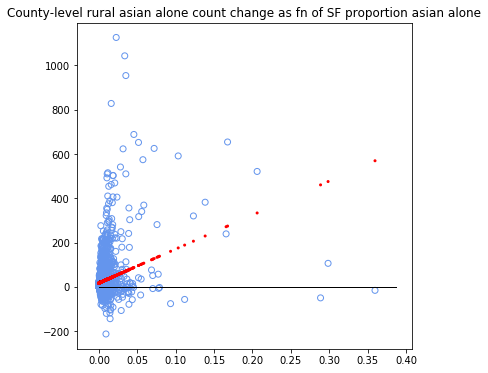

In [162]:
# plot preds
x = rural_county_level[["prop_asian_SF"]]
y = rural_county_level[["asian_count_diff"]] 
z = rural_county_level[["prop_asian_SF"]]*rural_asian_proportion_m+rural_asian_proportion_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('County-level rural asian alone count change as fn of SF proportion asian alone')

plt.show()

In [102]:
#rural asian bias
#exluding all rows where proportion is 0/0
X = rural_county_level[['P0030005_SF']]
y = rural_county_level[['asian_count_diff']]
rural_asian_size = linear_model.LinearRegression()
model = rural_asian_size.fit(X,y)

In [103]:
rural_asian_size_b = rural_asian_size.intercept_[0]
rural_asian_size_m = rural_asian_size.coef_[0]
print(f'''intercept: ,{rural_asian_size_b},
     coef: ,{rural_asian_size_m}''')

intercept: ,9.69617423895939,
     coef: ,[0.12698103]


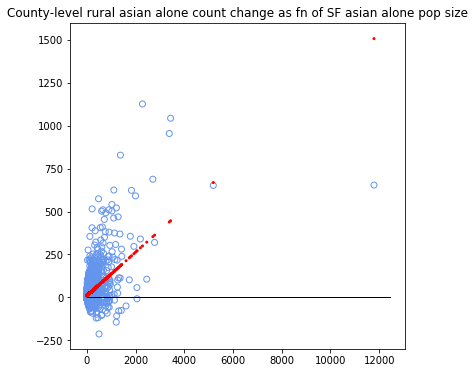

In [104]:
# plot preds
x = rural_county_level[["P0030005_SF"]]
y = rural_county_level[["asian_count_diff"]] 
z = rural_county_level[["P0030005_SF"]]*rural_asian_size_m+rural_asian_size_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('County-level rural asian alone count change as fn of SF asian alone pop size')

plt.show()

In [105]:
#rural asian bias
#exluding all rows where proportion is 0/0
X = rural_county_level[['P0010001_SF']]
y = rural_county_level[['asian_count_diff']]
rural_asian_total_size = linear_model.LinearRegression()
model = rural_asian_total_size.fit(X,y)

In [106]:
rural_asian_total_size_b = rural_asian_total_size.intercept_[0]
rural_asian_total_size_m = rural_asian_total_size.coef_[0]
print(f'''intercept: ,{rural_asian_total_size_b},
     coef: ,{rural_asian_total_size_m}''')

intercept: ,-6.034751871563525,
     coef: ,[0.0016788]


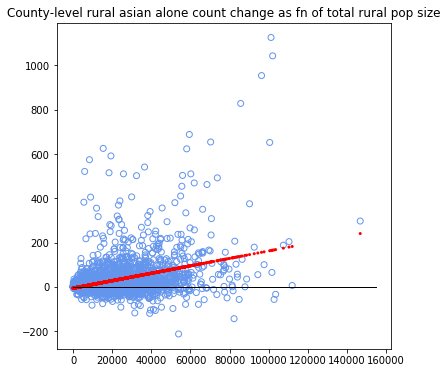

In [107]:
# plot preds
x = rural_county_level[["P0010001_SF"]]
y = rural_county_level[["asian_count_diff"]] 
z = rural_county_level[["P0010001_SF"]]*rural_asian_total_size_m+rural_asian_total_size_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('County-level rural asian alone count change as fn of total rural pop size')

plt.show()

In [108]:
# vars to try
# AIANHH, geographic location, % urban? if crosses state lines? %s and counts of other races?
# proportion of county rural & proportion of {some geo level (which?)} reservation

In [166]:
# add correlation matrix

In [167]:
urban_county_level['asian_count_diff'] = urban_county_level['P0030005_DP'] - urban_county_level['P0030005_SF']
urban_county_level['total_count_diff'] = urban_county_level['P0010001_DP'] - urban_county_level['P0010001_SF']
urban_county_level['prop_asian_SF'] = urban_county_level['P0030005_SF'] / urban_county_level['P0010001_SF']
urban_county_level['prop_asian_DP'] = urban_county_level['P0030005_DP'] / urban_county_level['P0010001_DP']

In [168]:
rural_county_level.shape

(3128, 22)

In [169]:
urban_county_level.columns

Index(['P0030001_SF', 'P0030002_SF', 'P0030003_SF', 'P0030004_SF',
       'P0030005_SF', 'P0030006_SF', 'P0030007_SF', 'P0030008_SF',
       'P0010001_SF', 'P0030001_DP', 'P0030002_DP', 'P0030003_DP',
       'P0030004_DP', 'P0030005_DP', 'P0030006_DP', 'P0030007_DP',
       'P0030008_DP', 'P0010001_DP', 'asian_count_diff', 'total_count_diff',
       'prop_asian_SF', 'prop_asian_DP'],
      dtype='object')

In [170]:
rural_county_level.columns

Index(['P0030001_SF', 'P0030002_SF', 'P0030003_SF', 'P0030004_SF',
       'P0030005_SF', 'P0030006_SF', 'P0030007_SF', 'P0030008_SF',
       'P0010001_SF', 'P0030001_DP', 'P0030002_DP', 'P0030003_DP',
       'P0030004_DP', 'P0030005_DP', 'P0030006_DP', 'P0030007_DP',
       'P0030008_DP', 'P0010001_DP', 'asian_count_diff', 'total_count_diff',
       'prop_asian_SF', 'prop_asian_DP'],
      dtype='object')

In [171]:
urban_county_level.shape

(2440, 22)

In [172]:
county_level_ur = pd.merge(rural_county_level,
                       urban_county_level,
                       left_on=['STATE', 'COUNTY'],
                       right_on=['STATE', 'COUNTY'],
                       suffixes=('_r', '_u'))

In [173]:
county_level_ur.shape

(2426, 44)

In [174]:
county_level_ur.columns

Index(['P0030001_SF_r', 'P0030002_SF_r', 'P0030003_SF_r', 'P0030004_SF_r',
       'P0030005_SF_r', 'P0030006_SF_r', 'P0030007_SF_r', 'P0030008_SF_r',
       'P0010001_SF_r', 'P0030001_DP_r', 'P0030002_DP_r', 'P0030003_DP_r',
       'P0030004_DP_r', 'P0030005_DP_r', 'P0030006_DP_r', 'P0030007_DP_r',
       'P0030008_DP_r', 'P0010001_DP_r', 'asian_count_diff_r',
       'total_count_diff_r', 'prop_asian_SF_r', 'prop_asian_DP_r',
       'P0030001_SF_u', 'P0030002_SF_u', 'P0030003_SF_u', 'P0030004_SF_u',
       'P0030005_SF_u', 'P0030006_SF_u', 'P0030007_SF_u', 'P0030008_SF_u',
       'P0010001_SF_u', 'P0030001_DP_u', 'P0030002_DP_u', 'P0030003_DP_u',
       'P0030004_DP_u', 'P0030005_DP_u', 'P0030006_DP_u', 'P0030007_DP_u',
       'P0030008_DP_u', 'P0010001_DP_u', 'asian_count_diff_u',
       'total_count_diff_u', 'prop_asian_SF_u', 'prop_asian_DP_u'],
      dtype='object')

In [175]:
county_level_ur['prop_rural_SF'] = county_level_ur['P0010001_SF_r'] / ( county_level_ur['P0010001_SF_r'] +  county_level_ur['P0010001_SF_u'])

In [176]:
county_level_ur.prop_rural_SF.head

<bound method NDFrame.head of STATE  COUNTY
1      1         0.420022
       3         0.422791
       5         0.677896
       7         0.683526
       9         0.899515
                   ...   
56     37        0.109163
       39        0.464309
       41        0.430959
       43        0.359545
       45        0.545366
Name: prop_rural_SF, Length: 2426, dtype: float64>

In [177]:
county_level_ur.asian_count_diff_r.head

<bound method NDFrame.head of STATE  COUNTY
1      1          10
       3         101
       5          39
       7           3
       9          45
                ... 
56     37         25
       39         22
       41         -4
       43         -7
       45         -9
Name: asian_count_diff_r, Length: 2426, dtype: int64>

In [178]:
#rural asian bias as function of proportion of county rural
X = county_level_ur[['prop_rural_SF']]
y = county_level_ur[['asian_count_diff_r']]
rural_aisan_prop_rural= linear_model.LinearRegression()
model = rural_aisan_prop_rural.fit(X,y)

In [179]:
rural_aisan_prop_rural_b = rural_aisan_prop_rural.intercept_[0]
rural_aisan_prop_rural_m = rural_aisan_prop_rural.coef_[0]
print(f'''intercept: ,{rural_aisan_prop_rural_b},
     coef: ,{rural_aisan_prop_rural_m}''')

intercept: ,87.33586984350816,
     coef: ,[-116.56368668]


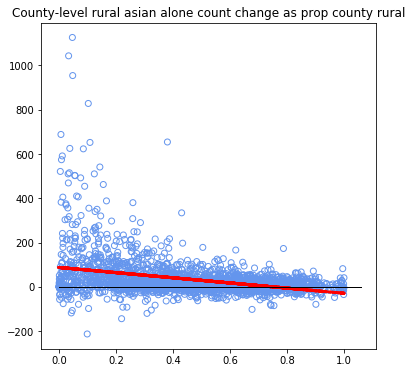

In [184]:
# plot preds
x = county_level_ur[['prop_rural_SF']]
y = county_level_ur[['asian_count_diff_r']]
z = county_level_ur[['prop_rural_SF']]*rural_aisan_prop_rural_m+rural_aisan_prop_rural_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('County-level rural asian alone count change as prop county rural')

plt.show()

In [194]:
county_level_ur['prop_rural_SF_round'] = np.around(county_level_ur.prop_rural_SF, decimals=2)

In [195]:
county_level_ur['prop_rural_var'] = np.zeros(county_level_ur.shape[0]) #create a column to hold variance value

In [198]:
#create a column of variance for aian_prop_SF
for i in county_level_ur[county_level_ur.prop_rural_SF_round.notna()].prop_rural_SF_round.unique():
    var = np.var(county_level_ur[(county_level_ur.prop_rural_SF_round == i)].asian_count_diff_r)
    county_level_ur.loc[(county_level_ur.prop_rural_SF_round == i),'prop_rural_var'] = var

In [199]:
county_level_ur.head()

P0030001_SF_r  P0030002_SF_r  P0030003_SF_r  P0030004_SF_r  \
STATE COUNTY                                                               
1     1               22921          17892           4411            110   
      3               77060          68304           5025            696   
      5               18613           9225           8440             51   
      7               15663          13208           2128             47   
      9               51562          48200            533            271   

              P0030005_SF_r  P0030006_SF_r  P0030007_SF_r  P0030008_SF_r  \
STATE COUNTY                                                               
1     1                  59              7            138            304   
      3                 335             16           1412           1272   
      5                  37             13            672            175   
      7                  13             13            100            154   
      9                  80             36           1831            611   

              P0010001_SF_r  P0030001_DP_r  ...  P0030008_DP_u  P0010001_DP_u  \
STATE COUNTY                                ...                                 
1     1               22921          23126  ...            497          31436   
      3               77060          77399  ...           1459         104615   
      5               18613          18721  ...            107           8780   
      7               15663          15927  ...             63           7069   
      9               51562          51883  ...             53           5435   

              asian_count_diff_u  total_count_diff_u  prop_asian_SF_u  \
STATE COUNTY                                                            
1     1                        5                -214         0.013112   
      3                     -131                -590         0.009629   
      5                       -1                 -64         0.007915   
      7                       -8                -183         0.001241   
      9                      -24                -325         0.006424   

              prop_asian_DP_u  prop_rural_SF  pct_change_asian_rural  \
STATE COUNTY                                                           
1     1              0.013360       0.420022                1.169492   
      3              0.008431       0.422791                1.301493   
      5              0.007859       0.677896                2.054054   
      7              0.000141       0.683526                1.230769   
      9              0.002392       0.899515                1.562500   

              prop_rural_SF_round  prop_rural_var  
STATE COUNTY                                       
1     1                      0.42     1326.395062  
      3                      0.42     1326.395062  
      5                      0.68      799.374567  
      7                      0.68      799.374567  
      9                      0.90     1075.322314  

[5 rows x 48 columns]

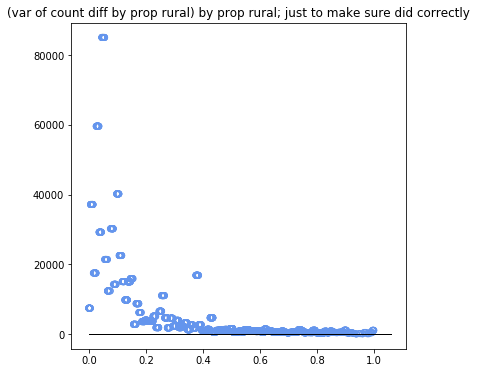

In [203]:
# plot preds
x = county_level_ur[['prop_rural_SF']]
y = county_level_ur[['prop_rural_var']]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
# ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('(var of count diff by prop rural) by prop rural; just to make sure did correctly')

plt.show()

In [206]:
#now looking to predict this var:
# county_level_ur[['prop_rural_var']]
county_level_ur.columns

Index(['P0030001_SF_r', 'P0030002_SF_r', 'P0030003_SF_r', 'P0030004_SF_r',
       'P0030005_SF_r', 'P0030006_SF_r', 'P0030007_SF_r', 'P0030008_SF_r',
       'P0010001_SF_r', 'P0030001_DP_r', 'P0030002_DP_r', 'P0030003_DP_r',
       'P0030004_DP_r', 'P0030005_DP_r', 'P0030006_DP_r', 'P0030007_DP_r',
       'P0030008_DP_r', 'P0010001_DP_r', 'asian_count_diff_r',
       'total_count_diff_r', 'prop_asian_SF_r', 'prop_asian_DP_r',
       'P0030001_SF_u', 'P0030002_SF_u', 'P0030003_SF_u', 'P0030004_SF_u',
       'P0030005_SF_u', 'P0030006_SF_u', 'P0030007_SF_u', 'P0030008_SF_u',
       'P0010001_SF_u', 'P0030001_DP_u', 'P0030002_DP_u', 'P0030003_DP_u',
       'P0030004_DP_u', 'P0030005_DP_u', 'P0030006_DP_u', 'P0030007_DP_u',
       'P0030008_DP_u', 'P0010001_DP_u', 'asian_count_diff_u',
       'total_count_diff_u', 'prop_asian_SF_u', 'prop_asian_DP_u',
       'prop_rural_SF', 'pct_change_asian_rural', 'prop_rural_SF_round',
       'prop_rural_var'],
      dtype='object')

In [207]:
#rural asian pct bias as function of proportion of county rural
X = county_level_ur[['P0030005_SF_r']]
y = county_level_ur[['prop_rural_var']]
count_diff_var_by_asian_size= linear_model.LinearRegression()
model = count_diff_var_by_asian_size.fit(X,y)

In [209]:
count_diff_var_by_asian_size_b = count_diff_var_by_asian_size.intercept_[0]
count_diff_var_by_asian_size_m = count_diff_var_by_asian_size.coef_[0]
print(f'''intercept: ,{count_diff_var_by_asian_size_b},
     coef: ,{count_diff_var_by_asian_size_m}''')

intercept: ,4064.77967931738,
     coef: ,[9.21445229]


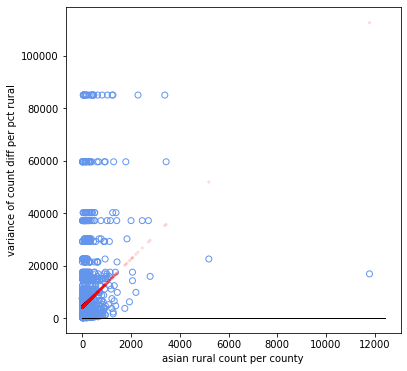

In [216]:
# plot preds
x = county_level_ur[['P0030005_SF_r']]
y = county_level_ur[['prop_rural_var']]
z = county_level_ur[['P0030005_SF_r']]*count_diff_var_by_asian_size_m+count_diff_var_by_asian_size_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.', alpha = 0.15)

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

plt.xlabel('asian rural count per county')
plt.ylabel('variance of count diff per pct rural')
# plt.title('County-level rural asian alone pct change as fn of proportion of county rural')

plt.show()

In [214]:
#rural asian pct bias as function of proportion of county rural
X = county_level_ur[['P0030002_SF_r']]
y = county_level_ur[['prop_rural_var']]
asian_count_diff_var_by_white_size= linear_model.LinearRegression()
model = asian_count_diff_var_by_white_size.fit(X,y)

In [215]:
asian_count_diff_var_by_white_size_b = asian_count_diff_var_by_white_size.intercept_[0]
asian_count_diff_var_by_white_size_m = asian_count_diff_var_by_white_size.coef_[0]
print(f'''intercept: ,{asian_count_diff_var_by_white_size_b},
     coef: ,{asian_count_diff_var_by_white_size_m}''')

intercept: ,4613.826182041188,
     coef: ,[0.04547352]


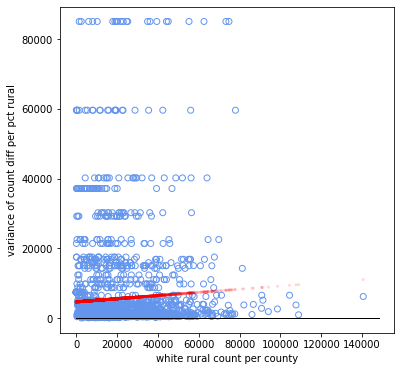

In [218]:
# plot preds
x = county_level_ur[['P0030002_SF_r']]
y = county_level_ur[['prop_rural_var']]
z = county_level_ur[['P0030002_SF_r']]*asian_count_diff_var_by_white_size_m+asian_count_diff_var_by_white_size_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.', alpha = 0.15)

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

plt.xlabel('white rural count per county')
plt.ylabel('variance of count diff per pct rural')
# plt.title('County-level rural asian alone pct change as fn of proportion of county rural')

plt.show()

In [219]:
#rural asian pct bias as function of proportion of county rural
X = county_level_ur[['P0010001_SF_u']]
y = county_level_ur[['prop_rural_var']]
asian_count_diff_var_by_urban_size= linear_model.LinearRegression()
model = asian_count_diff_var_by_urban_size.fit(X,y)

In [220]:
asian_count_diff_var_by_urban_size_b = asian_count_diff_var_by_urban_size.intercept_[0]
asian_count_diff_var_by_urban_size_m = asian_count_diff_var_by_urban_size.coef_[0]
print(f'''intercept: ,{asian_count_diff_var_by_urban_size_b},
     coef: ,{asian_count_diff_var_by_urban_size_m}''')

intercept: ,3941.561465825642,
     coef: ,[0.01549687]


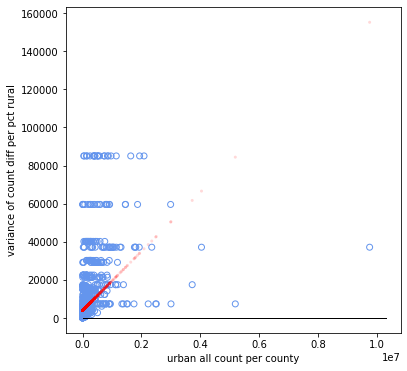

In [222]:
# plot preds
x = county_level_ur[['P0010001_SF_u']]
y = county_level_ur[['prop_rural_var']]
z = county_level_ur[['P0010001_SF_u']]*asian_count_diff_var_by_urban_size_m+asian_count_diff_var_by_urban_size_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.', alpha = 0.15)

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

plt.xlabel('urban all count per county')
plt.ylabel('variance of count diff per pct rural')
# plt.title('County-level rural asian alone pct change as fn of proportion of county rural')

plt.show()

# variance x (each race) 

In [ ]:
## Encoding of race vars
# White alone P0030002
# Black or African American alone P0030003
# American Indian and Alaska Native alone P0030004
# Asian alone P0030005
# Native Hawaiian and Other Pacific Islander alone P0030006 
# Some Other Race alone P0030007 
# Two or More Races P0030008 

In [223]:
#rural asian pct bias as function of proportion of county rural
X = county_level_ur[['P0030002_SF_r','P0030003_SF_r','P0030004_SF_r','P0030005_SF_r','P0030006_SF_r','P0030007_SF_r',
                    'P0030008_SF_r']]
y = county_level_ur[['prop_rural_var']]
asian_count_diff_var_by_rural_races_all= linear_model.LinearRegression()
model = asian_count_diff_var_by_rural_races_all.fit(X,y)

In [225]:
asian_count_diff_var_by_rural_races_all.intercept_

array([5585.60155348])

In [226]:
asian_count_diff_var_by_rural_races_all.coef_

array([[ -0.10892075,  -0.25394481,  -0.17687308,  19.26439739,
        -19.96270561,   0.74286685,  -1.57981795]])

In [224]:
asian_count_diff_var_by_urban_size_b = asian_count_diff_var_by_rural_races_all.intercept_[0]
asian_count_diff_var_by_urban_size_m = asian_count_diff_var_by_rural_races_all.coef_[0]
print(f'''intercept: ,{asian_count_diff_var_by_urban_size_b},
     coef: ,{asian_count_diff_var_by_urban_size_m}''')

intercept: ,3941.561465825642,
     coef: ,[0.01549687]


In [227]:
county_level_ur['pct_change_asian_rural'] = county_level_ur['P0030005_DP_r'] / county_level_ur['P0030005_SF_r']

In [228]:
county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural!=np.inf)]['pct_change_asian_rural'].describe()

AttributeError: 'DataFrame' object has no attribute 'pct_change_aian_rural'

In [366]:
#rural asian pct bias as function of proportion of county rural
X = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural!=np.inf)][['prop_rural_SF']]
y = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural!=np.inf)][['pct_change_asian_rural']]
pct_change_rural_aisan_prop_rural= linear_model.LinearRegression()
model = pct_change_rural_aisan_prop_rural.fit(X,y)

In [367]:
pct_change_rural_aisan_prop_rural_b = pct_change_rural_aisan_prop_rural.intercept_[0]
pct_change_rural_aisan_prop_rural_m = pct_change_rural_aisan_prop_rural.coef_[0]
print(f'''intercept: ,{pct_change_rural_aisan_prop_rural_b},
     coef: ,{pct_change_rural_aisan_prop_rural_m}''')

intercept: ,1.630148557667134,
     coef: ,[-0.52099038]


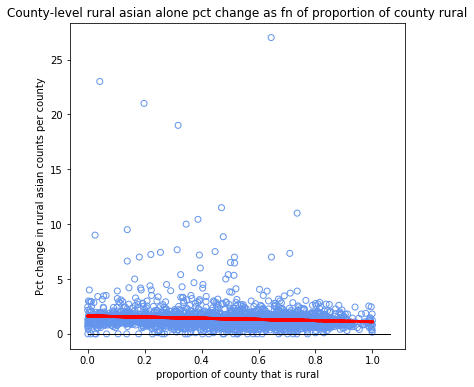

In [369]:
# plot preds
x = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural!=np.inf)][['prop_rural_SF']]
y = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural!=np.inf)][['pct_change_asian_rural']]
z = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural!=np.inf)][['prop_rural_SF']]*pct_change_rural_aisan_prop_rural_m+pct_change_rural_aisan_prop_rural_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

plt.xlabel('proportion of county that is rural')
plt.ylabel('Pct change in rural asian counts per county')
plt.title('County-level rural asian alone pct change as fn of proportion of county rural')

plt.show()

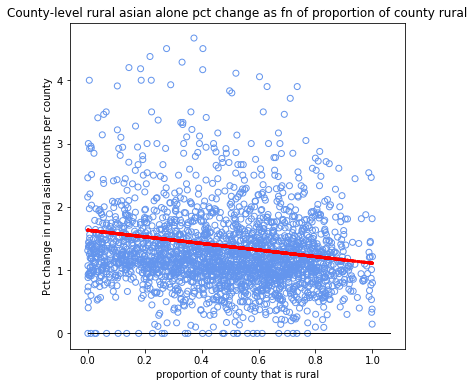

In [371]:
# plot preds
x = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural<5)][['prop_rural_SF']]
y = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural<5)][['pct_change_asian_rural']]
z = county_level_ur[(county_level_ur.pct_change_aian_rural.notna()) &
                (county_level_ur.pct_change_aian_rural<5)][['prop_rural_SF']]*pct_change_rural_aisan_prop_rural_m+pct_change_rural_aisan_prop_rural_b

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, z, facecolors='red', edgecolors = 'none', marker = '.')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'black', linewidth=1)

plt.xlabel('proportion of county that is rural')
plt.ylabel('Pct change in rural asian counts per county')
plt.title('County-level rural asian alone pct change as fn of proportion of county rural')

plt.show()